In [ ]:
#| code-fold: true
#| code-summary: "Show `pip install`s"
!pip install transformers -Uqq
!pip install accelerate -qq
!pip install torch==2.2.2 -qq
!pip install datasets~=2.16.1 -qq
!pip install scikit-learn==1.2 -qq

In [5]:
#| code-fold: true
#| code-summary: "Show imports"
from datasets import load_dataset, Dataset
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import random

from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-0.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

In [ ]:
#| code-fold: true
#| code-summary: "Show dataset loading functions"
# load dataset
dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree", 
    split="train"  # note that the dataset does not have a default test split
)

# create a new column with the numeric label verbalised as label_text (e.g. "positive" instead of "0")
label_map = {i: label_text for i, label_text in enumerate(dataset.features["label"].names)}

def add_label_text(example):
    example["label_text"] = label_map[example["label"]]
    return example

dataset = dataset.map(add_label_text)

print(dataset)

In [8]:
#| code-fold: true
#| code-summary: "Show `generate_response` function"
def generate_response(prompt):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=2
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

In [9]:
#| code-fold: true
#| code-summary: "Show `add_prompt` and `generate_responses` functions"
def add_prompt(item, prompt):
        item['prompt'] = prompt.format(text=item['sentence'])
        return item
    
def generate_responses(dataset, prompt):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    print(dataset[0]['prompt'])
    
    for row in dataset:
        messages = [
            {"role": "user", "content": row['prompt']}
        ]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=2
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
        responses.append(response)
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    #df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    
    return df, acc

In [10]:
#| code-fold: true
#| code-summary: "Show `make_cm` function"
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['responses'], labels=['negative', 'neutral', 'positive', 'other'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive', 'other'])
    
    # I chose 8x8 so it fits on one screen but still is large
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax,text_kw={'fontsize': 16}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

In [11]:
#| code-fold: true
#| code-summary: "Show `ds_subset` function"
def ds_subset(dataset, exclude_idxs, columns=[0, 1, 2]):
    idxs = list(range(len(dataset)))
    idxs = [x for x in idxs if x not in exclude_idxs]
    ddf = dataset.to_pandas()
    new_ds = Dataset.from_pandas(ddf.iloc[idxs, columns])
    return new_ds

In [12]:
#| code-fold: true
#| code-summary: "Show `few_shot_responses`function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    print(dataset[0]['prompt'])
    
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    for row in dataset:
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=2
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
        responses.append(response)
        
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    
    return df

In [13]:
#| code-fold: true
#| code-summary: "Show `get_acc` function"
def get_acc(df):
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return acc

In [14]:
#| code-fold: true
#| code-summary: "Show `get_ds` function"
def get_ds(n):
    exclude_idxs = [random.randint(0, 2263) for _ in range(n)]
    prompt_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

    examples = []
    for idx in exclude_idxs:
        examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
        
    print(prompt_ds, [el[1] for el in examples[:10]])
    
    return prompt_ds, examples

## Background

In this notebook I'll use [Qwen2-0.5B-Instruct](https://huggingface.co/Qwen/Qwen2-0.5B-Instruct) 
to classify sentiment in the [`financial_phrasebank` dataset](https://huggingface.co/datasets/financial_phrasebank).
In previous notebooks I have performed 
[sentiment classification with Qwen2-1.5B-Instruct](https://vishalbakshi.github.io/blog/posts/2024-09-23-tinysentiment-Qwen2-1.5B-sentiment-classification/),
[phi-2](https://vishalbakshi.github.io/blog/posts/2024-08-31-tinysentiment-phi-2-sentiment-classification/),
[phi-3](https://vishalbakshi.github.io/blog/posts/2024-09-12-tinysentiment-phi-3-sentiment-classification/), 
[phi-3.5](https://vishalbakshi.github.io/blog/posts/2024-09-12-tinysentiment-phi-3-5-sentiment-classification/), 
and [the Claude series](https://vishalbakshi.github.io/blog/posts/2024-08-29-tinysentiment-claude-experiments/).

This notebook is part of [a series of blog posts](https://vishalbakshi.github.io/blog/#category=TinySentiment) for a project I’m working called TinySentiment where I’m experimenting with tiny models to improve their ability to classify sentiment in the `financial_phrasebank dataset`. I was inspired to do so after reading [this blog post](https://huggingface.co/blog/synthetic-data-save-costs) and [this corresponding notebook](https://github.com/MoritzLaurer/synthetic-data-blog/blob/main/notebooks/synthetic_data_creation.ipynb) by Moritz Laurer as part of a fastai study group last year.

Here are the results from my experiments so far (\**the best-performing prompt from this notebook):

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|phi-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|
|Qwen2-1.5B|27-Shot|86.10%|90% (264/294)|96% (1320/1382)|61% (342/561)|
|\**Qwen2-0.5B|17-Shot|79.48%|69% (206/300)|86% (1180/1380)|71% (400/567)|

Here are the results from this notebook:

| Prompt | Strategy | Accuracy | Negative | Neutral | Positive |
|--------|----------|-----------|-----------|----------|-----------|
| [A](#prompt-a) | 0-Shot | 62.41% | 91% (276/303) | 53% (735/1391) | 71% (402/570) |
| [B](#prompt-b) | 0-Shot | 47.84% | 90% (274/303) | 57% (789/1391) | 4% (20/570) |
| [C](#prompt-c) | 0-Shot | 40.46% | 91% (276/303) | 43% (594/1391) | 8% (46/570) |
| [D](#prompt-d) | 0-Shot | 68.29% | 79% (240/303) | 61% (851/1391) | 80% (455/570) |
| [E](#prompt-e) | 0-Shot | 51.19% | 97% (293/303) | 28% (396/1391) | 82% (470/570) |
| [F](#prompt-f) | 0-Shot | 48.19% | 94% (286/303) | 21% (287/1391) | 91% (518/570) |
| [G](#prompt-g) | 0-Shot | 61.09% | 93% (282/303) | 46% (646/1391) | 80% (455/570) |
| [H](#prompt-h) | 0-Shot | 65.42% | 85% (257/303) | 57% (798/1391) | 75% (426/570) |
| [I](#prompt-i) | 0-Shot | 66.12% | 81% (245/303) | 58% (800/1391) | 79% (452/570) |
| [J](#prompt-j) | 3-Shot | 70.94% | 43% (131/302) | 75% (1042/1390) | 76% (431/569) |
| [K](#prompt-k) | 3-Shot | 74.88% | 67% (201/302) | 75% (1043/1390) | 79% (449/569) |
| [L](#prompt-l) | 3-Shot | 68.11% | 49% (149/302) | 65% (900/1390) | 86% (491/569) |
| [M](#prompt-m) | 3-Shot | 56.97% | 49% (149/302) | 45% (625/1390) | 90% (514/569) |
| [N](#prompt-n) | 3-Shot | 73.95% | 62% (188/302) | 75% (1038/1390) | 78% (446/569) |
| [O](#prompt-o) | 3-Shot | 59.97% | 65% (196/302) | 46% (635/1390) | 92% (525/569) |
| [P](#prompt-p) | 6-Shot | 63.91% | 95% (289/303) | 49% (678/1389) | 84% (476/566) |
| [Q](#prompt-q) | 6-Shot | 65.72% | 69% (207/302) | 55% (765/1389) | 90% (512/567) |
| [R](#prompt-r) | 6-Shot | 64.84% | 94% (285/303) | 49% (686/1387) | 87% (493/568) |
| [S](#prompt-s) | 6-Shot | 62.98% | 96% (292/303) | 47% (656/1387) | 83% (474/568) |
| [T](#prompt-t) | 6-Shot | 68.87% | 51% (155/302) | 70% (966/1387) | 76% (434/569) |
| [U](#prompt-u) | 12-Shot | 65.50% | 53% (159/302) | 59% (820/1386) | 88% (496/564) |
| [V](#prompt-v) | 12-Shot | 73.22% | 70% (209/300) | 80% (1103/1386) | 60% (337/566) |
| [W](#prompt-w) | 12-Shot | 70.43% | 82% (246/301) | 66% (912/1384) | 75% (428/567) |
| [X](#prompt-x) | 12-Shot | 76.60% | 91% (270/298) | 72% (1000/1386) | 80% (455/568) |
| [Y](#prompt-y) | 12-Shot | 72.56% | 80% (243/303) | 77% (1069/1381) | 57% (322/568) |
| [Z](#prompt-z) | 18-Shot | 71.33% | 50% (150/301) | 75% (1036/1382) | 74% (416/563) |
| **[AA](#prompt-aa)** | **17-Shot** | **79.48%** | 69% (206/300) | 86% (1180/1380) | 71% (400/567) |
| [AB](#prompt-ab) | 18-Shot | 74.22% | 77% (229/299) | 76% (1054/1381) | 68% (384/566) |
| [AC](#prompt-ac) | 18-Shot | 68.57% | 49% (148/302) | 73% (1013/1380) | 67% (379/564) |
| [AD](#prompt-ad) | 18-Shot | 74.98% | 89% (271/303) | 76% (1052/1379) | 64% (361/564) |
| [AE](#prompt-ae) | 24-Shot | 74.91% | 61% (181/299) | 92% (1267/1375) | 41% (230/566) |
| [AF](#prompt-af) | 24-Shot | 73.08% | 37% (112/302) | 91% (1246/1375) | 50% (279/563) |
| [AG](#prompt-ag) | 24-Shot | 75.00% | 58% (173/300) | 92% (1265/1375) | 43% (242/565) |
| [AH](#prompt-ah) | 24-Shot | 77.46% | 78% (233/299) | 84% (1153/1375) | 62% (349/566) |
| [AI](#prompt-ai) | 23-Shot | 75.37% | 48% (143/301) | 92% (1266/1375) | 50% (280/565) |
| [AJ](#prompt-aj) | 30-Shot | 77.39% | 58% (172/298) | 94% (1284/1370) | 48% (273/566) |
| [AK](#prompt-ak) | 30-Shot | 67.78% | 63% (187/299) | 61% (844/1375) | 86% (483/560) |
| [AL](#prompt-al) | 30-Shot | 76.54% | 58% (173/299) | 86% (1185/1372) | 63% (352/563) |
| [AM](#prompt-am) | 30-Shot | 74.84% | 82% (242/296) | 72% (984/1376) | 79% (446/562) |
| [AN](#prompt-an) | 30-Shot | 73.81% | 51% (154/300) | 77% (1052/1372) | 79% (443/562) |
| [AO](#prompt-ao) | 45-Shot | 74.18% | 54% (159/297) | 76% (1034/1366) | 81% (453/556) |
| [AP](#prompt-ap) | 45-Shot | 78.73% | 63% (186/296) | 87% (1192/1365) | 66% (369/558) |
| [AQ](#prompt-aq) | 45-Shot | 72.01% | 17% (51/301) | 89% (1210/1359) | 60% (337/559) |
| [AR](#prompt-ar) | 45-Shot | 73.86% | 53% (157/297) | 80% (1094/1364) | 70% (388/558) |
| [AS](#prompt-as) | 45-Shot | 74.94% | 42% (125/297) | 89% (1219/1363) | 57% (319/559) |
| [AT](#prompt-at) | 60-Shot | 72.19% | 47% (138/292) | 78% (1055/1356) | 72% (398/556) |
| [AU](#prompt-au) | 60-Shot | 76.86% | 43% (127/296) | 91% (1237/1356) | 60% (330/552) |
| [AV](#prompt-av) | 60-Shot | 75.45% | 26% (79/299) | 89% (1206/1352) | 68% (378/553) |
| [AW](#prompt-aw) | 60-Shot | 74.46% | 29% (88/299) | 86% (1157/1349) | 71% (396/556) |
| **[AX](#prompt-ax)** | **60-Shot** | **79.63%** | 62% (179/290) | 94% (1275/1352) | 54% (301/562) |


## Prompt A

I'll start out with a simple instruction.

In [10]:
promptA = """Label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}"""

print(promptA)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}


In [11]:
formatted_prompt = promptA.format(text=dataset[0]['sentence'])
print(formatted_prompt)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [13]:
generate_response(formatted_prompt)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


'Negative.'

Good---at least it's responding with a sensible answer, although it's not formatted how I'd like to be, so I expect to need more data cleaning 
than Qwen2-1.5B-Instruct's responses.

At ~35ms per prompt it will take about 80 seconds to run inference on the full 2264 item dataset.

In [14]:
%timeit -n 10 generate_response(formatted_prompt)

35.4 ms ± 472 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
df, acc = generate_responses(dataset, promptA)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


0.5B yields messier responses. Note the period at the end of some of the strings. For now I'll manually check each set of responses and clean them accordingly.

In [14]:
df['responses'].unique()

array(['neutral.', 'positive', 'neutral', 'negative', 'positive.',
       'negative.', 'negot', 'negative profit', 'net interest', 'teleste',
       'neglig'], dtype=object)

In [15]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 

In [16]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")

0.5B doesn't do terribly on this simple prompt (62.4% accuracy) but it's almost 20% less accurate than 1.5B (~82% accuracy).

In [17]:
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.6241166077738516

0.5B does a great job at classifying `negative` sentiment, does quite well at `positive` sentences, and has very few `other` responses overall.

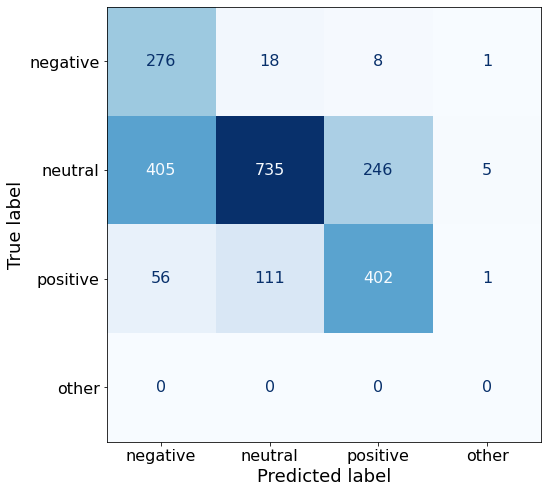

In [18]:
make_cm(df)

In [19]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_A.csv', index=False)

## Prompt B

In [28]:
promptB = """Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [29]:
df, acc = generate_responses(dataset, promptB)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral


With this prompt (where the instruction is repeated after the dataset text) 0.5B responds much more cleanly.

In [30]:
df['responses'].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

However, it performs almost 20% worse!

In [31]:
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.47835689045936397

While it's quite good still with `negative` sentiment, it performs significantly worse on `positive` sentences.

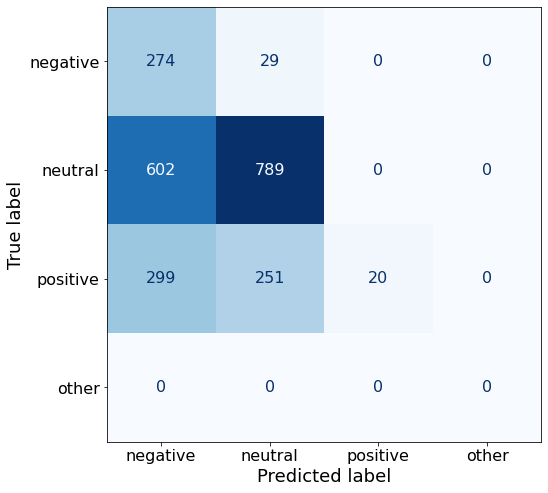

In [32]:
make_cm(df)

In [33]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_B.csv', index=False)

## Prompt C

I'll use the same Prompt C as the 1.5B model: a reword of Prompt A (which performed well for 0.5B).

In [20]:
promptC = """Respond with a single word: negative, positive, or neutral
TEXT: {text}"""

In [21]:
df, acc = generate_responses(dataset, promptC)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Respond with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [22]:
df['responses'].unique()

array(['negative.', 'negative', 'neutral', 'neutral.', 'positive',
       'positive.', 'negative loss'], dtype=object)

The change in prompt language significantly deteriorates 0.5B's accuracy.

In [23]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.4045936395759717

0.5B still does really well on `negative` sentiment, but does horribly on `positive` and underwhelming for `neutral` sentences.

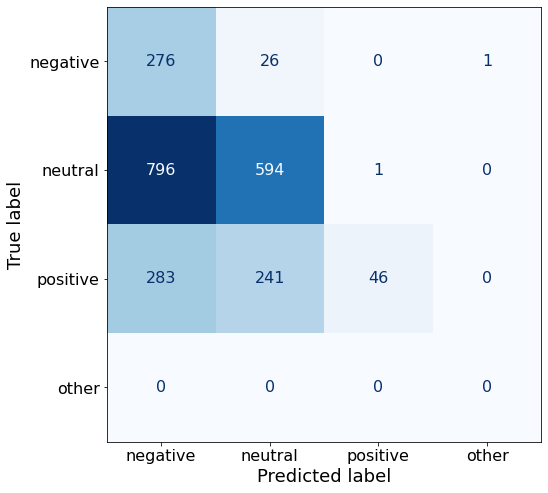

In [24]:
make_cm(df)

In [25]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_C.csv', index=False)

## Prompt D

I'll change the order of sentiment listed in Prompt A by putting `positive` first:

In [26]:
promptD = """Label the following TEXT with a single word: positive, negative, or neutral
TEXT: {text}"""

In [27]:
df, acc = generate_responses(dataset, promptD)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [28]:
df['responses'].unique()

array(['neutral.', 'positive', 'positive.', 'neutral', 'net income',
       'the text', 'negative', 'negative.', 'negative net', 'negot',
       'subscription'], dtype=object)

Changing the order of sentiment (putting `positive` first) increases the overall accuracy by ~6%.

In [29]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.6828621908127208

0.5B's performance on `negative` sentiment dips a bit (36 fewer correct) but that is more than compensated by the increase in correctly classified 
`positive` (+53) and `neutral` (+166) sentences.

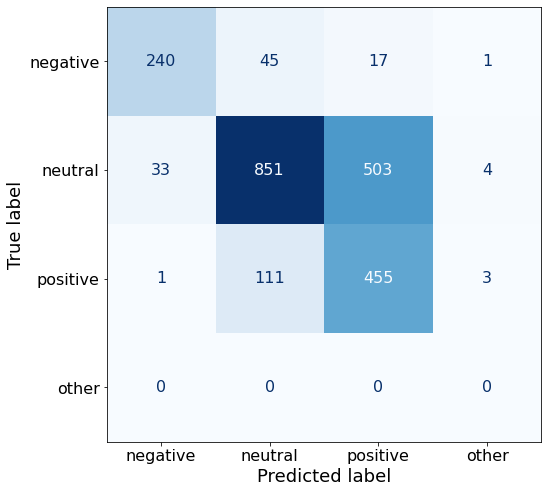

In [30]:
make_cm(df)

In [31]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_D.csv', index=False)

## Prompt E

I'll try another combination:

In [33]:
promptE = """Label the following TEXT with a single word: negative, neutral, or positive
TEXT: {text}"""

In [34]:
df, acc = generate_responses(dataset, promptE)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, neutral, or positive
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [35]:
df['responses'].unique()

array(['negative.', 'positive', 'negative', 'positive.', 'neutral.',
       'neutral', 'negative profit', 'negot', 'teleste'], dtype=object)

This ordering of sentiment worsens the accuracy by 10 points.

In [36]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.5119257950530035

0.5B is nearly perfect for `negative` sentiment, and quite good with `positive` sentences, but abysmal for `neutral`.

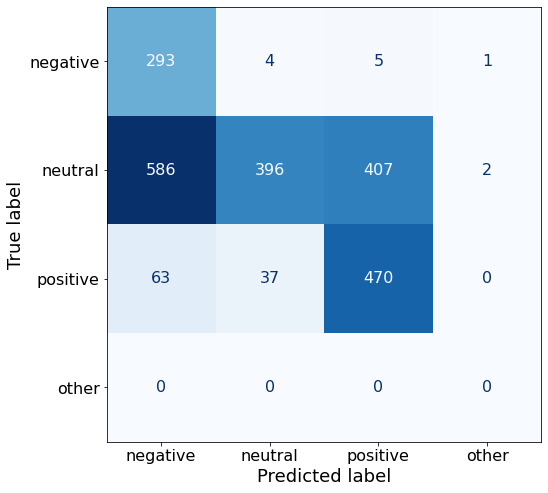

In [37]:
make_cm(df)

In [38]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_E.csv', index=False)

## Prompt F

Trying the next permutation of sentiments:

In [39]:
promptF = """Label the following TEXT with a single word: positive, neutral, or negative
TEXT: {text}"""

In [40]:
df, acc = generate_responses(dataset, promptF)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, neutral, or negative
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [41]:
df['responses'].unique()

array(['neutral.', 'positive', 'positive.', 'negative', 'negative.',
       'neutral', 'positive net', 'negativ', 'negot', 'subscription'],
      dtype=object)

This ordering of sentiments further worsens the overall accuracy.

In [42]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.4818904593639576

`positive` sentences are classified correctly at the highest rate so far, and `negative` sentiment accuracy is very good, but the model does terribly 
on `neutral` sentences.

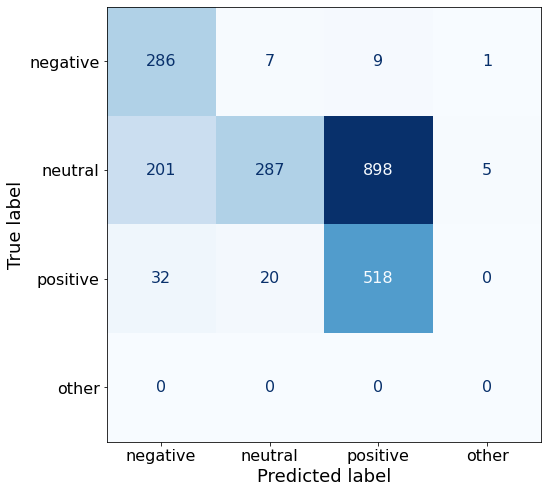

In [44]:
make_cm(df)

In [45]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_F.csv', index=False)

## Prompt G

The next ordering of sentiments:

In [46]:
promptG = """Label the following TEXT with a single word: neutral, negative, or positive
TEXT: {text}"""

In [47]:
df, acc = generate_responses(dataset, promptG)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: neutral, negative, or positive
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [48]:
df['responses'].unique()

array(['neutral.', 'positive', 'positive.', 'neutral', 'negative',
       'negative.', 'positive profit', 'negot'], dtype=object)

The accuracy of 61% is worse than the best-performing Prompt D (68%).

In [49]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.6108657243816255

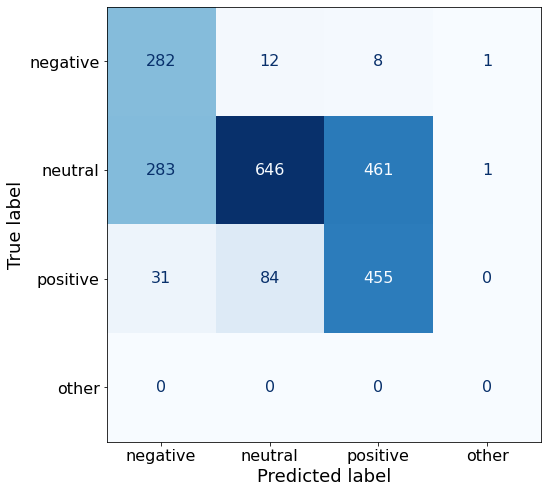

In [50]:
make_cm(df)

In [51]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_G.csv', index=False)

## Prompt H

The last ordering of sentiment:

In [52]:
promptH = """Label the following TEXT with a single word: neutral, positive, or negative
TEXT: {text}"""

In [53]:
df, acc = generate_responses(dataset, promptH)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: neutral, positive, or negative
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [54]:
df['responses'].unique()

array(['positive', 'neutral.', 'positive.', 'neutral', 'negative',
       'negative.', 'positive profit', 'negot'], dtype=object)

This yields a 65% accuracy.

In [55]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.6541519434628975

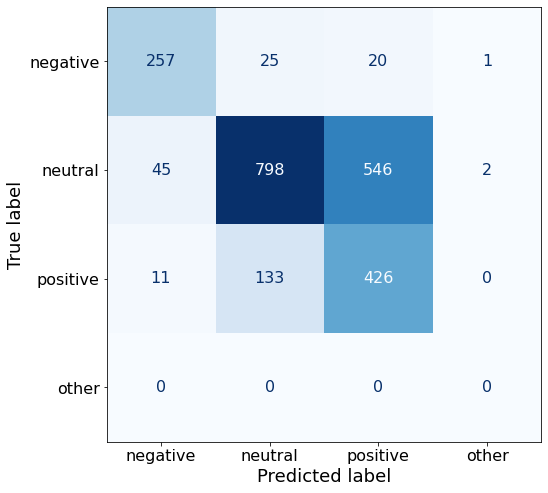

In [56]:
make_cm(df)

In [57]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_H.csv', index=False)

## Prompt I

I'll make a small change to my best-performing prompt by adding a period at the end of the instruction.

In [14]:
promptI = """Label the following TEXT with a single word: positive, negative, or neutral.
TEXT: {text}"""

In [15]:
df, acc = generate_responses(dataset, promptI)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [16]:
df['responses'].unique()

array(['neutral.', 'positive', 'positive.', 'neutral', 'net income',
       'negative', 'negative.', 'negative profit', 'nord', 'negot',
       'the text', 'negation', 'neglig', 'subscription'], dtype=object)

Adding a period to the end of the instruction worsens the accuracy a bit.

In [17]:
df['responses'] = df['responses'].str.replace('.', '', regex=False) 
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.6612190812720848

Adding a period worsens the performance on `neutral` by 51 sentences.

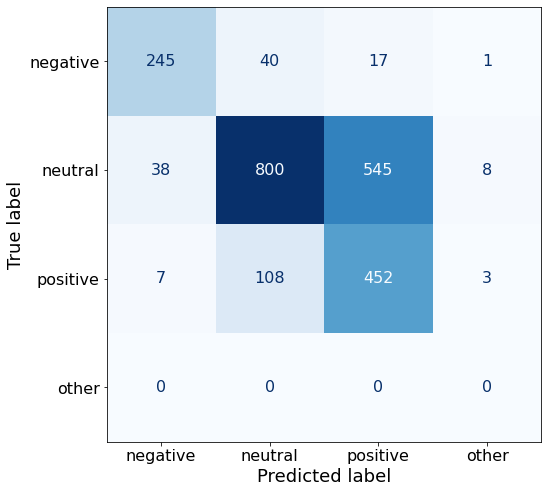

In [18]:
make_cm(df)

In [19]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_I.csv', index=False)

## Prompt J

I'll now shift my attention to few-shot prompts, starting with 3-Shot.

In [11]:
exclude_idxs = [0, 1, 292]

In [12]:
promptJ_ds = ds_subset(dataset, exclude_idxs)
promptJ_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [13]:
promptJ = """Label the following TEXT with a single word: positive, negative, or neutral
TEXT: {text}"""

Since ordering seems to matter, I'll start with a `neutral` example, `positive` example and `negative` example.

In [23]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative')]

In [25]:
df = few_shot_responses(promptJ_ds, promptJ, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


In [26]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

3-Shot prompting resulted in the best accuracy so far! ~71%.

In [27]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.709420610349403

Compared to my best 0-Shot Prompt D (68%) this prompt results in the model significantly underperforming on `negative` sentences, (131 < 240), 
but more than making up for it on `neutral` sentences (1042 > 851). 

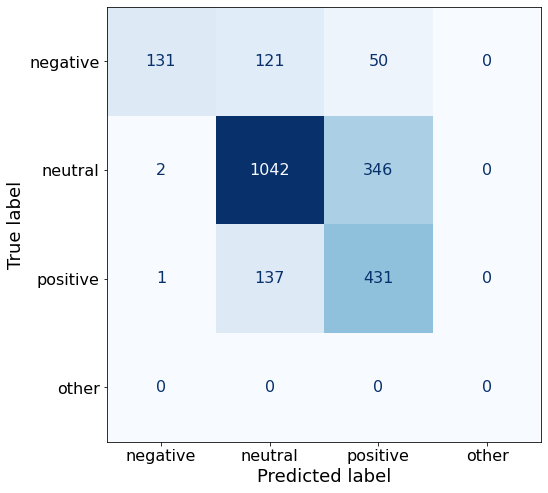

In [28]:
make_cm(df)

In [29]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_J.csv', index=False)

## Prompt K

I'll re-order the examples and use the same Prompt J.

In [36]:
exclude_idxs = [0, 292, 1]

In [37]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive')]

In [38]:
df = few_shot_responses(promptJ_ds, promptJ, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


In [40]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

Changing the order of examples to `neutral`, `negative`, `positive` increases the overall accuracy to almost 75%!

In [41]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.7487837240159222

The model improves on all three sentiments compared to Prompt J.

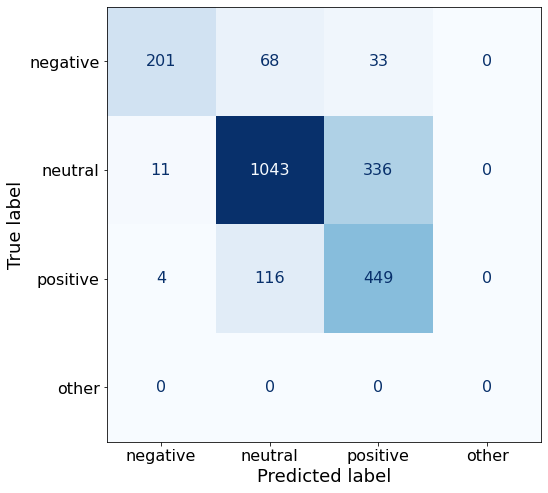

In [42]:
make_cm(df)

In [43]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_K.csv', index=False)

## Prompt L

I'll re-order the examples and use the same Prompt J.

In [48]:
exclude_idxs = [1, 0, 292]

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative')]

In [49]:
df = few_shot_responses(promptJ_ds, promptJ, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


In [50]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

This ordering of examples drops the accuracy to 68%.

In [51]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.6811145510835913

Compared to the best-performing Prompt K, this prompt yields a better accuracy for `positive` sentences (491 > 449).

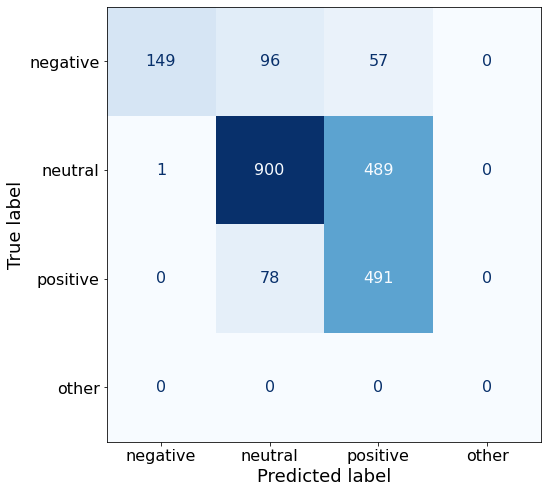

In [52]:
make_cm(df)

In [53]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_L.csv', index=False)

## Prompt M

I'll re-order the examples and use the same Prompt J.

In [56]:
exclude_idxs = [1, 292, 0]

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative'),
 ('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral')]

In [57]:
df = few_shot_responses(promptJ_ds, promptJ, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


In [58]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

This ordering of examples worsens the accuracy, dropping it down to 57%.

In [59]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.5696594427244582

This prompt yields better results for `positive` sentiment (514 > 449) than the best overall performing Prompt J.

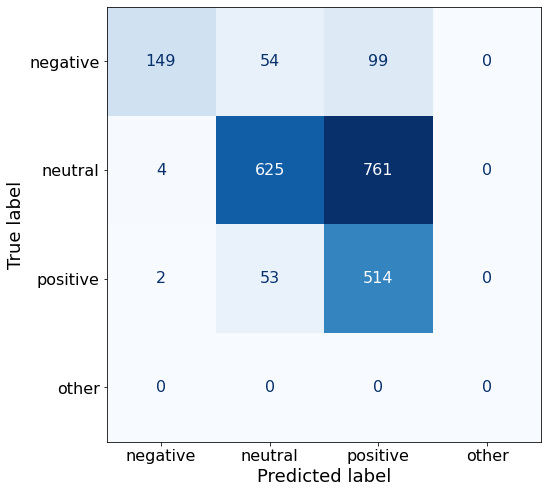

In [60]:
make_cm(df)

In [61]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_M.csv', index=False)

## Prompt N

Trying the next ordering of sentiments:

In [15]:
exclude_idxs = [292, 0, 1]

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative'),
 ('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive')]

In [19]:
df = few_shot_responses(promptJ_ds, promptJ, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


In [20]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

This ordering results in the second-highest overall accuracy at 74%.

In [21]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.7394957983193278

This prompt performs slightly worse for all three sentiments than the so far best-overall performing Prompt K.

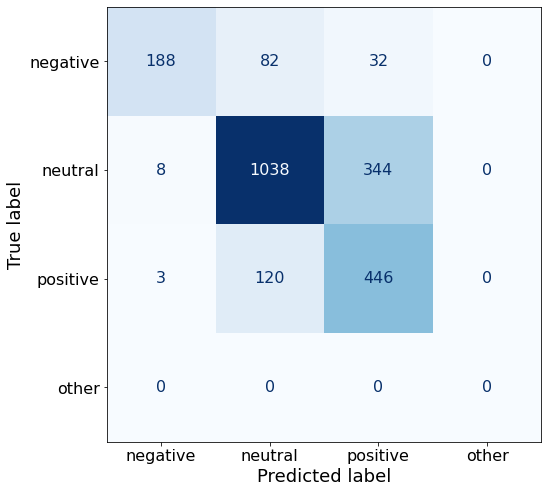

In [22]:
make_cm(df)

In [23]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_N.csv', index=False)

## Prompt O

Here's the final 3-sentiment ordering:

In [26]:
exclude_idxs = [292, 1, 0]

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral')]

In [27]:
df = few_shot_responses(promptJ_ds, promptJ, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


In [28]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

This ordering of sentiment does not beat my so far best-performing accuracy.

In [29]:
df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
df['lm_match'] = df['label_text'] == df['responses']
acc = df.lm_match.mean()
acc

0.599734630694383

This prompt yields a much better performance on `positive` sentiment than my best performing Prompt K (525 > 449).

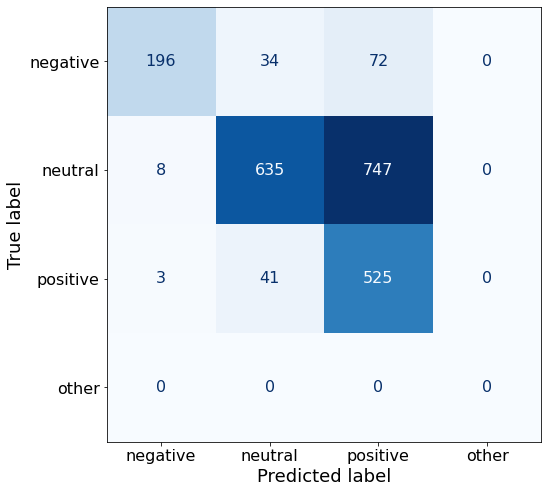

In [30]:
make_cm(df)

In [31]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_O.csv', index=False)

## Prompt P

Next, I'll increase the number of examples to 6. Note that I won't be trying all permutations but a few random ones.

In [36]:
exclude_idxs = [random.randint(0, 2263) for _ in range(6)]
promptP_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptP_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2258
})

The random examples I have picked don't include a `negative` sentence. I'm curious to see how the model performs on this.

In [40]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

[el[1] for el in examples]

['positive', 'neutral', 'positive', 'neutral', 'positive', 'positive']

In [42]:
df = few_shot_responses(promptP_ds, promptJ, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [43]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt results in a worse performance in overall accuracy.

In [44]:
get_acc(df)

0.6390611160318866

Even though no `negative` examples were given, this prompt yields considerably more 
correct `negative` sentences (289) than the best-performing Prompt K (201).

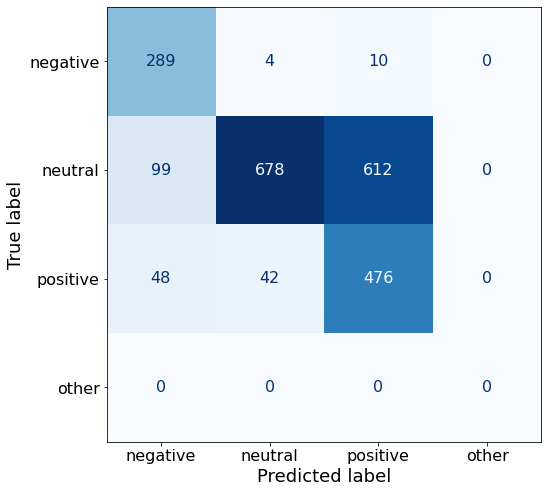

In [45]:
make_cm(df)

In [46]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_P.csv', index=False)

## Prompt Q

I'll try another random set of 6 examples, this time making sure there's at least one of each sentiment.

In [48]:
exclude_idxs = [random.randint(0, 2263) for _ in range(6)]
promptQ_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
promptQ_ds, [el[1] for el in examples]

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2258
 }),
 ['positive', 'positive', 'positive', 'neutral', 'negative', 'neutral'])

In [49]:
df = few_shot_responses(promptQ_ds, promptJ, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [50]:
df['responses'].unique()

array(['neutral', 'positive', 'negative', 'live'], dtype=object)

This set of 6 examples does not improve upon the best-overall accuracy of 75%.

In [51]:
get_acc(df)

0.6572187776793623

Something we haven't seen in awhile, an `other` response.

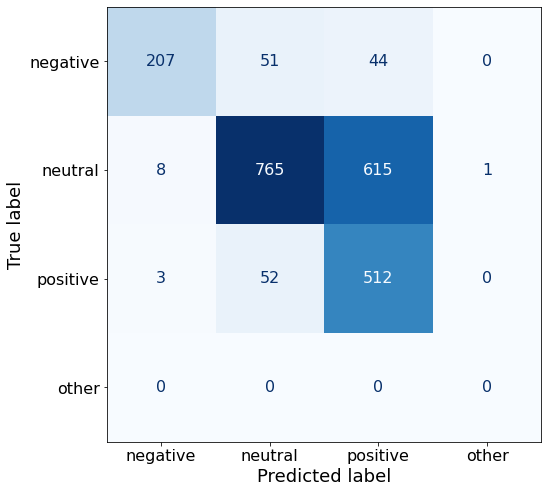

In [52]:
make_cm(df)

In [53]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_Q.csv', index=False)

## Prompt R

In [54]:
exclude_idxs = [random.randint(0, 2263) for _ in range(6)]
promptR_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
promptR_ds, [el[1] for el in examples]

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2258
 }),
 ['neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral'])

In [55]:
df = few_shot_responses(promptR_ds, promptJ, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [56]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

No improvements on accuracy with this prompt.

In [57]:
get_acc(df)

0.6483613817537643

Compared to the best-performing Prompt K, this prompt yields considerably more correct `negative` (285 > 201) 
and `positive` (493 > 449) sentences but underperforms on `neutral` sentences (686 < 1043).

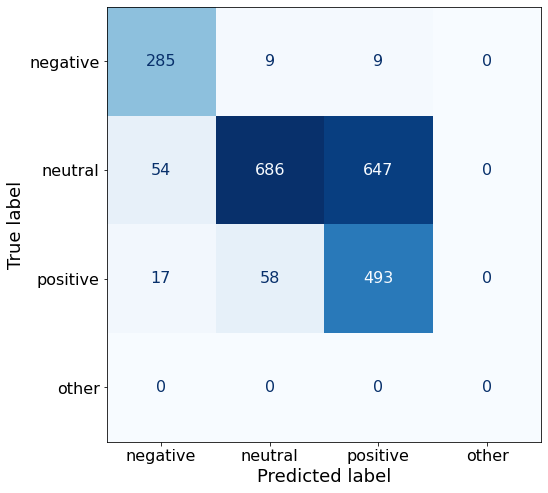

In [58]:
make_cm(df)

In [59]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_R.csv', index=False)

## Prompt S

In [12]:
exclude_idxs = [random.randint(0, 2263) for _ in range(6)]
promptS_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
promptS_ds, [el[1] for el in examples]

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2258
 }),
 ['neutral', 'neutral', 'positive', 'neutral', 'positive', 'neutral'])

This set of examples has no `negative` sentences and a majority of `neutral` sentences.

In [13]:
df = few_shot_responses(promptS_ds, promptJ, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [14]:
df['responses'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

This set of examples does not improve on the best-overall accuracy of 75% (Prompt K).

In [17]:
get_acc(df)

0.6297608503100088

It does, however, have a considerably larger number of correctly labeled `negative` sentences (292 > 201).

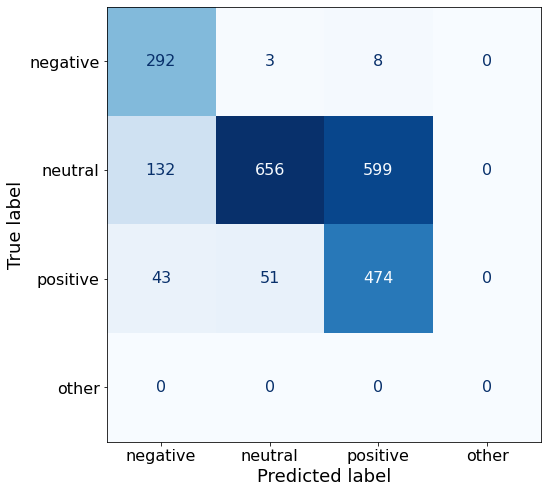

In [18]:
make_cm(df)

In [19]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_S.csv', index=False)

I'll try one more 6-shot prompt before I increase the number of examples.

## Prompt T

In [28]:
exclude_idxs = [random.randint(0, 2263) for _ in range(6)]
promptT_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
promptT_ds, [el[1] for el in examples]

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2258
 }),
 ['neutral', 'neutral', 'positive', 'neutral', 'negative', 'neutral'])

In [29]:
df = few_shot_responses(promptT_ds, promptJ, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [30]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Similar to the other 6-Shot examples, this set of examples does not improve on the best overall accuracy.

In [31]:
get_acc(df)

0.6886625332152347

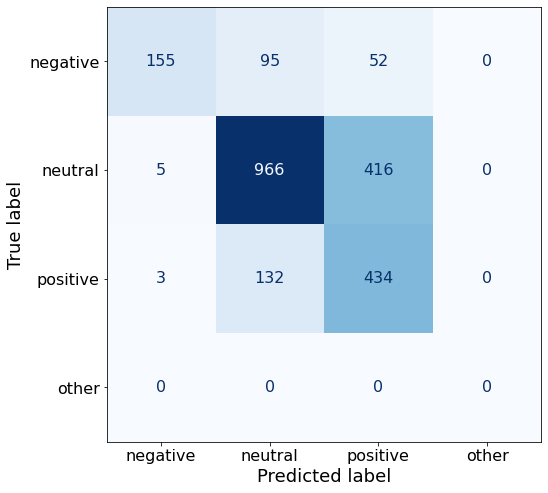

In [32]:
make_cm(df)

In [33]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_T.csv', index=False)

## Prompt U

I'll now increase the number of examples in the prompt to 12, and try out 5 random sets of 12 examples.

In [34]:
exclude_idxs = [random.randint(0, 2263) for _ in range(12)]
promptU_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
promptU_ds, [el[1] for el in examples]

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2252
 }),
 ['positive',
  'negative',
  'positive',
  'neutral',
  'positive',
  'positive',
  'neutral',
  'positive',
  'neutral',
  'neutral',
  'positive',
  'neutral'])

In [35]:
df = few_shot_responses(promptU_ds, promptJ, examples)

Map:   0%|          | 0/2252 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [36]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Increasing the number of examples to 12, at least the 12 I chose here, doesn't improve on the best overall accuracy.

In [37]:
get_acc(df)

0.6549733570159858

The number of correct `positive` sentences is considerably higher than Prompt K (496 > 449).

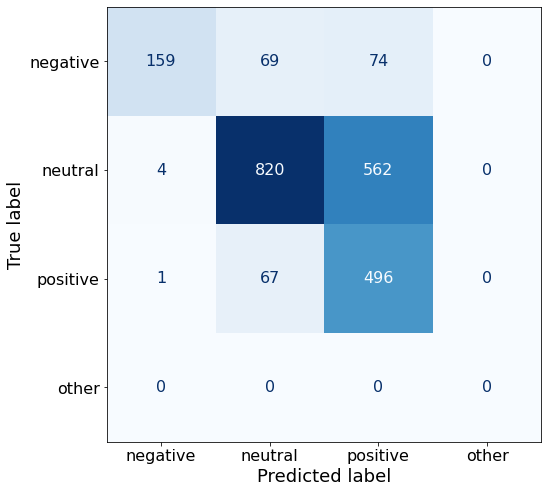

In [38]:
make_cm(df)

In [39]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_U.csv', index=False)

## Prompt V

In [40]:
exclude_idxs = [random.randint(0, 2263) for _ in range(12)]
promptV_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
promptV_ds, [el[1] for el in examples]

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2252
 }),
 ['neutral',
  'positive',
  'positive',
  'neutral',
  'neutral',
  'negative',
  'negative',
  'neutral',
  'positive',
  'neutral',
  'positive',
  'negative'])

In [41]:
df = few_shot_responses(promptV_ds, promptJ, examples)

Map:   0%|          | 0/2252 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .


In [42]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

This prompt performs well, and competes with but doesn't improve upon the best overall accuracy of 75%.

In [43]:
get_acc(df)

0.7322380106571936

This prompt performs considerably better on `neutral` sentences than Prompt K (1103 > 1043).

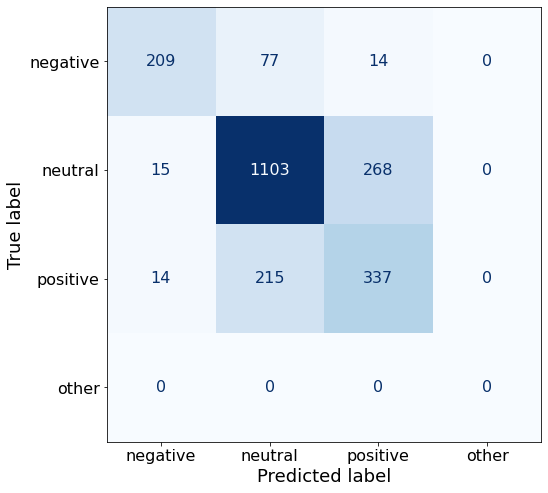

In [44]:
make_cm(df)

In [45]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_V.csv', index=False)

## Prompt W

In [47]:
exclude_idxs = [random.randint(0, 2263) for _ in range(12)]
promptW_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
promptW_ds, [el[1] for el in examples]

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2252
 }),
 ['neutral',
  'negative',
  'neutral',
  'positive',
  'neutral',
  'neutral',
  'positive',
  'neutral',
  'neutral',
  'negative',
  'positive',
  'neutral'])

In [48]:
df = few_shot_responses(promptW_ds, promptJ, examples)

Map:   0%|          | 0/2252 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [49]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The accuracy worsens with this set of 12 examples.

In [50]:
get_acc(df)

0.7042628774422736

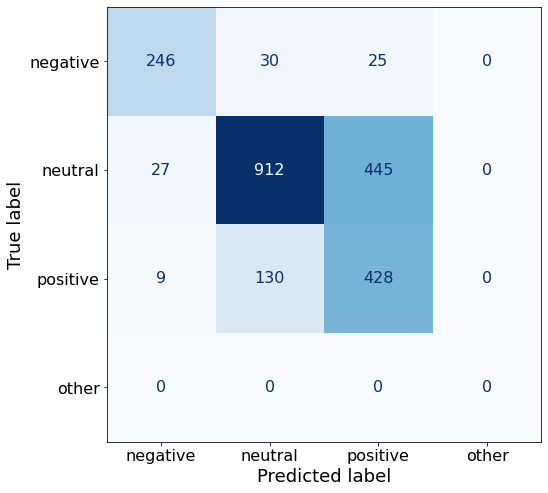

In [51]:
make_cm(df)

In [52]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_W.csv', index=False)

## Prompt X

In [15]:
def get_ds(n):
    exclude_idxs = [random.randint(0, 2263) for _ in range(n)]
    prompt_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

    examples = []
    for idx in exclude_idxs:
        examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
        
    print(prompt_ds, [el[1] for el in examples])
    
    return prompt_ds, examples

In [16]:
promptX_ds, examples = get_ds(12)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2252
}) ['positive', 'neutral', 'negative', 'neutral', 'positive', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'negative']


In [17]:
df = few_shot_responses(promptX_ds, promptJ, examples)

Map:   0%|          | 0/2252 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [18]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Aha! This prompt improves upon the best overall accuracy, reaching about 77%.

In [19]:
get_acc(df)

0.7659857904085258

Compared to Prompt K (75%) this prompt performs worse on `neutral` sentences (1000 < 1043) but more than makes up for it on 
`negative` (270 > 201) and `positive` (455 > 449) sentences.

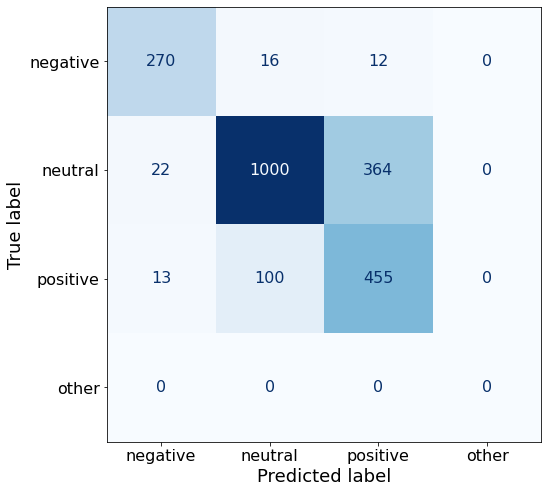

In [20]:
make_cm(df)

In [21]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_X.csv', index=False)

## Prompt Y

In [22]:
promptY_ds, examples = get_ds(12)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2252
}) ['neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'neutral']


In [23]:
df = few_shot_responses(promptY_ds, promptJ, examples)

Map:   0%|          | 0/2252 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [24]:
df['responses'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

This prompt does not improve on the best overall accuracy.

In [25]:
get_acc(df)

0.7255772646536413

This prompt performs well on `negative` and `neutral` sentences but its worse performance on `positive` sentences brings down the 
overall accuracy.

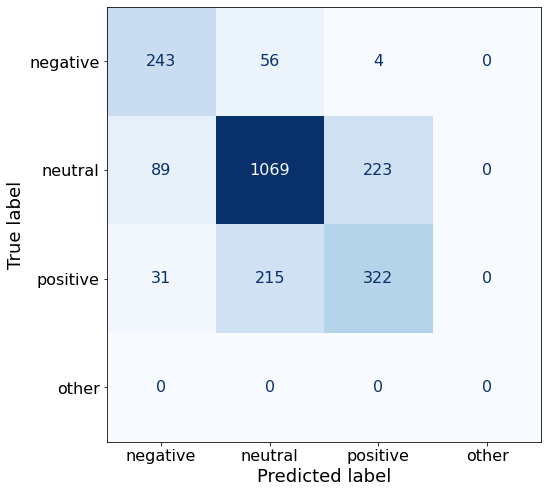

In [26]:
make_cm(df)

In [27]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_Y.csv', index=False)

Next, I'll try 5 prompts with 18 examples.

## Prompt Z

In [28]:
promptZ_ds, examples = get_ds(18)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2246
}) ['neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'positive', 'positive', 'neutral', 'positive', 'negative', 'negative', 'positive', 'neutral']


In [29]:
df = few_shot_responses(promptZ_ds, promptJ, examples)

Map:   0%|          | 0/2246 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [30]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt does not improve upon overall accuracy.

In [31]:
get_acc(df)

0.7132680320569902

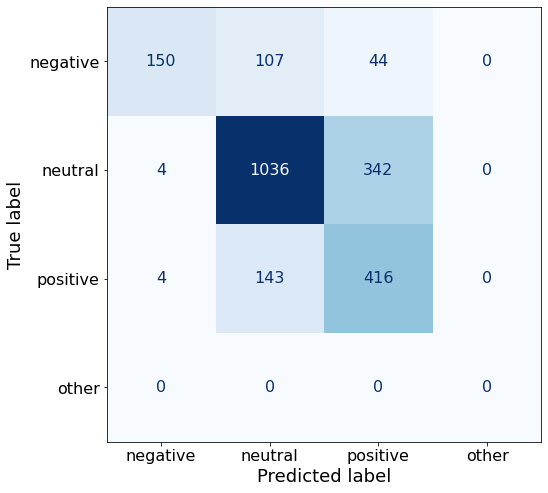

In [32]:
make_cm(df)

In [33]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_Z.csv', index=False)

## Prompt AA

In [34]:
promptAA_ds, examples = get_ds(18)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2247
}) ['neutral', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'positive', 'neutral']


In [35]:
df = few_shot_responses(promptAA_ds, promptJ, examples)

Map:   0%|          | 0/2247 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [36]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This set of 18 examples increases the best overall accuraacy to almost 80%!

In [37]:
get_acc(df)

0.7948375611927013

Compared to Prompt X, this prompt performs worse on `negative` (206 < 270) and `positive` (400 < 455) but more than makes up for it 
on `neutral` sentences (1180 > 1000).

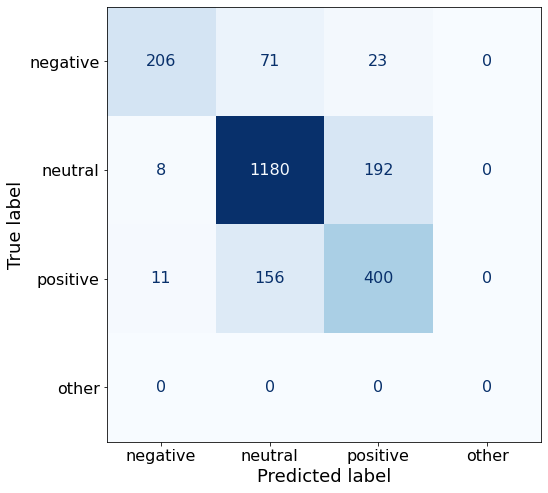

In [38]:
make_cm(df)

In [39]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AA.csv', index=False)

## Prompt AB

In [40]:
promptAB_ds, examples = get_ds(18)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2246
}) ['neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'positive', 'positive']


In [41]:
df = few_shot_responses(promptAB_ds, promptJ, examples)

Map:   0%|          | 0/2246 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [42]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt does not improve upon the best overall accuracy.

In [43]:
get_acc(df)

0.7422083704363313

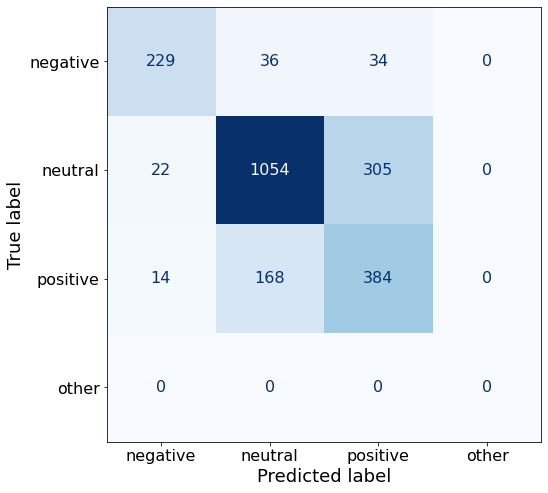

In [44]:
make_cm(df)

In [45]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AB.csv', index=False)

## Prompt AC

In [14]:
promptAC_ds, examples = get_ds(18)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2246
}) ['neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'neutral']


In [15]:
df = few_shot_responses(promptAC_ds, promptJ, examples)

Map:   0%|          | 0/2246 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [16]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt does not improve upon the best overall accuracy.

In [17]:
get_acc(df)

0.6856634016028496

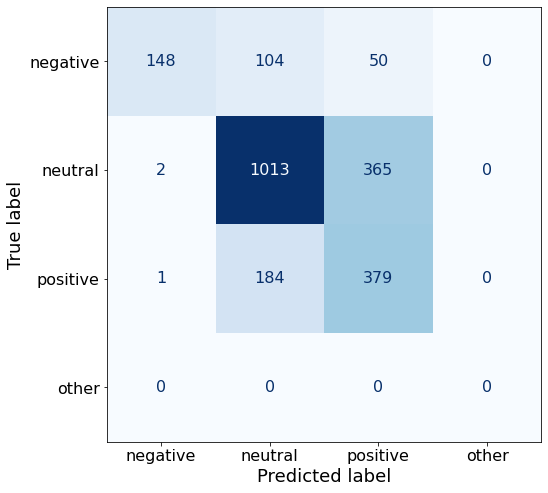

In [18]:
make_cm(df)

In [19]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AC.csv', index=False)

## Prompt AD

In [20]:
promptAD_ds, examples = get_ds(18)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2246
}) ['neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'positive']


In [21]:
df = few_shot_responses(promptAD_ds, promptJ, examples)

Map:   0%|          | 0/2246 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [22]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt does not improve upon the best overall accuracy.

In [23]:
get_acc(df)

0.7497773820124666

This prompt yields considerably more correct `negative` sentences (271 > 206) than the best-performing Prompt AA.

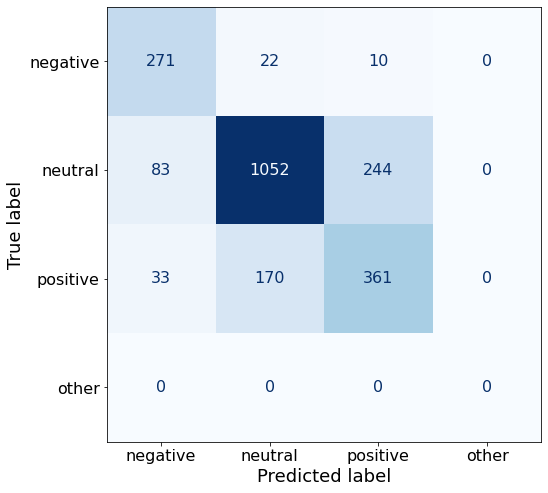

In [24]:
make_cm(df)

In [25]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AD.csv', index=False)

Next, I'll try 5 prompts with 24 examples each.

## Prompt AE

In [30]:
promptAE_ds, examples = get_ds(24)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2240
}) ['neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'negative']


In [31]:
df = few_shot_responses(promptAE_ds, promptJ, examples)

Map:   0%|          | 0/2240 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [32]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Increasing the number of examples to 24 (at least for these 24 examples) does not improve upon the overall accuracy.

In [33]:
get_acc(df)

0.7491071428571429

Compared to the best performing Prompt AA, this prompt yields considerably more correct `neutral` sentences (1267 > 1180).

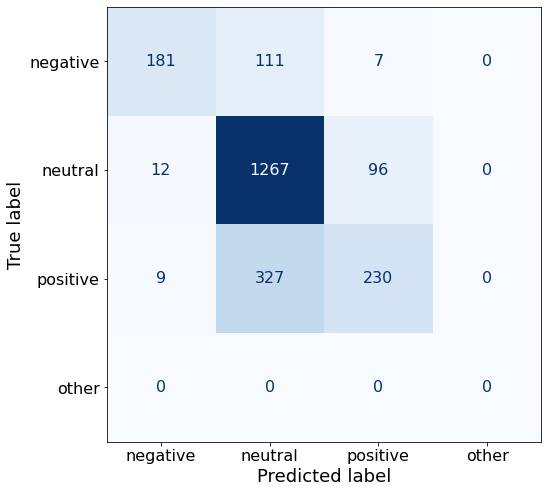

In [34]:
make_cm(df)

In [35]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AE.csv', index=False)

## Prompt AF

In [37]:
promptAF_ds, examples = get_ds(24)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2240
}) ['positive', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


In [38]:
df = few_shot_responses(promptAF_ds, promptJ, examples)

Map:   0%|          | 0/2240 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [39]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt doesn't improve upon the best overall accuracy, and performs better than Prompt AA on `neutral` sentences.

In [40]:
get_acc(df)

0.7308035714285714

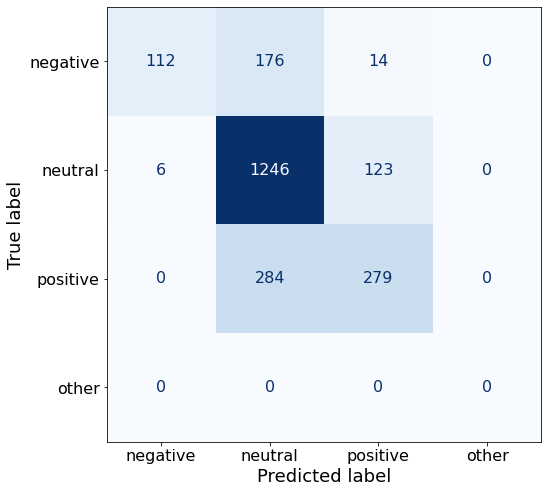

In [41]:
make_cm(df)

In [42]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AF.csv', index=False)

## Prompt AG

In [43]:
promptAG_ds, examples = get_ds(24)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2240
}) ['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral']


In [44]:
df = few_shot_responses(promptAG_ds, promptJ, examples)

Map:   0%|          | 0/2240 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [45]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The same trend continues for this set of 24 examples.

In [46]:
get_acc(df)

0.75

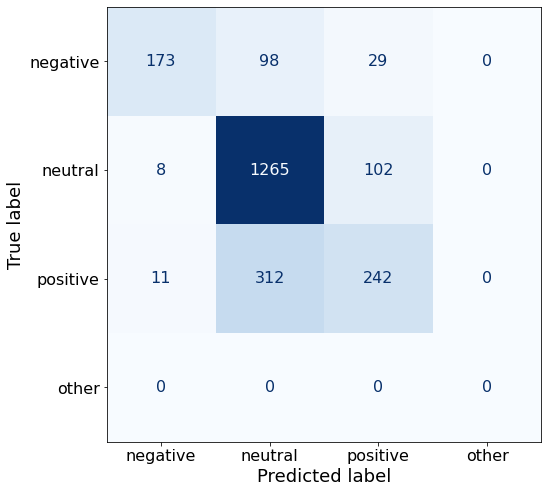

In [47]:
make_cm(df)

In [48]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AG.csv', index=False)

Two more 24-Shot prompts to go.

## Prompt AH

In [14]:
promptAH_ds, examples = get_ds(24)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2240
}) ['positive', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'neutral', 'neutral']


In [15]:
df = few_shot_responses(promptAH_ds, promptJ, examples)

Map:   0%|          | 0/2240 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [16]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt does not improve upon the best overall accuracy (though it comes close).

In [17]:
get_acc(df)

0.7745535714285714

This prompt yields more correct `negative` sentences than Prompt AA (233 > 206).

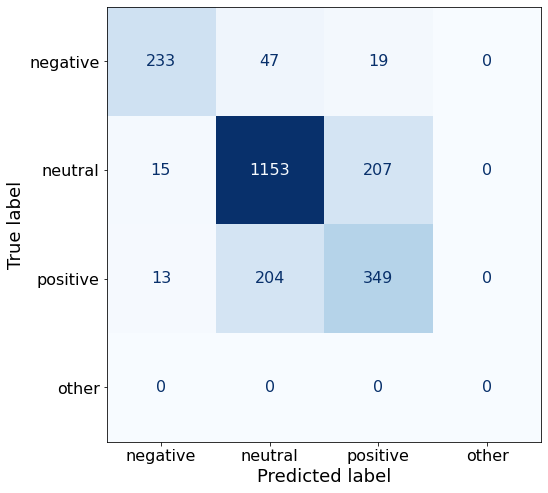

In [18]:
make_cm(df)

In [19]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AH.csv', index=False)

## Prompt AI

In [20]:
promptAI_ds, examples = get_ds(24)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2241
}) ['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'positive', 'neutral']


In [21]:
df = few_shot_responses(promptAI_ds, promptJ, examples)

Map:   0%|          | 0/2241 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [22]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt does not improve upon the best overall accuracy.

In [23]:
get_acc(df)

0.7536813922356091

This prompt yields considerably more correct `neutral` sentences than the best performing Prompt AA (1266 > 1180).

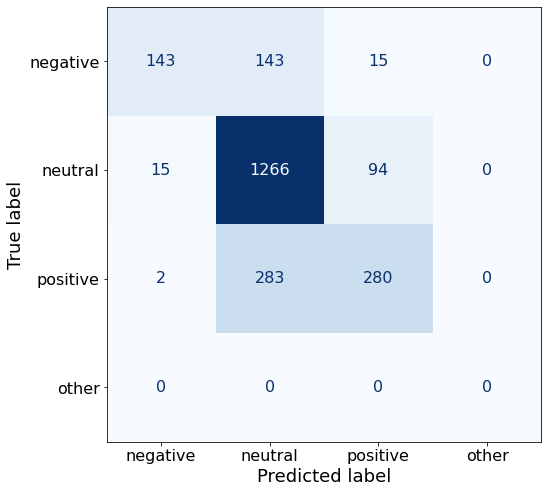

In [24]:
make_cm(df)

In [25]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AI.csv', index=False)

Next, I'll try 5 different 30-Shot prompts.

## Prompt AJ

In [26]:
promptAJ_ds, examples = get_ds(30)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
}) ['neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'negative', 'neutral', 'neutral']


In [27]:
df = few_shot_responses(promptAJ_ds, promptJ, examples)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [28]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt doesn't improve the best overall accuracy.

In [29]:
get_acc(df)

0.7739480752014324

As seems to be the trend, this prompt results in more correct `neutral` responses (1284) than Prompt AA (1180).

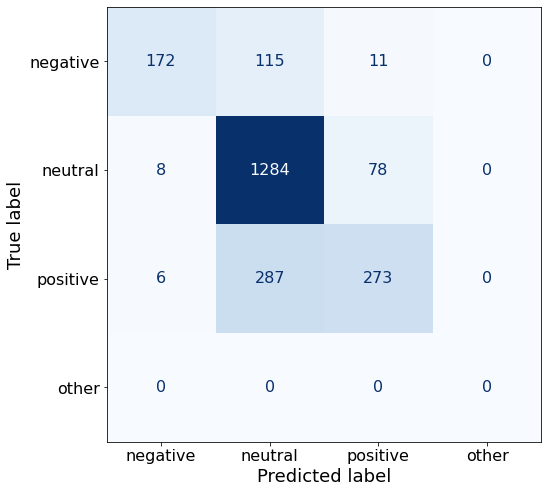

In [30]:
make_cm(df)

In [31]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AJ.csv', index=False)

## Prompt AK

In [32]:
promptAK_ds, examples = get_ds(30)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
}) ['neutral', 'neutral', 'neutral', 'negative', 'negative', 'positive', 'neutral', 'neutral', 'positive', 'positive']


In [33]:
df = few_shot_responses(promptAK_ds, promptJ, examples)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [34]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The model performs considerably worse with these 30 examples.

In [35]:
get_acc(df)

0.6777081468218442

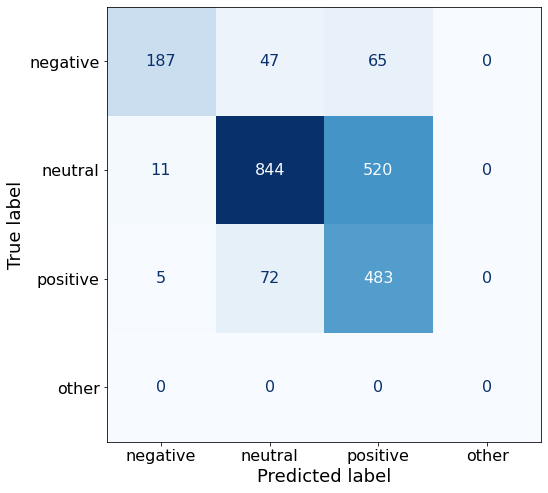

In [36]:
make_cm(df)

In [37]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AK.csv', index=False)

## Prompt AL

In [22]:
promptAL_ds, examples = get_ds(30)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
}) ['positive', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


In [23]:
df = few_shot_responses(promptAL_ds, promptJ, examples)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [24]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The trend continues: the overall accuracy doesn't improve but the model's performance on `neutral` sentences does.

In [25]:
get_acc(df)

0.76544315129812

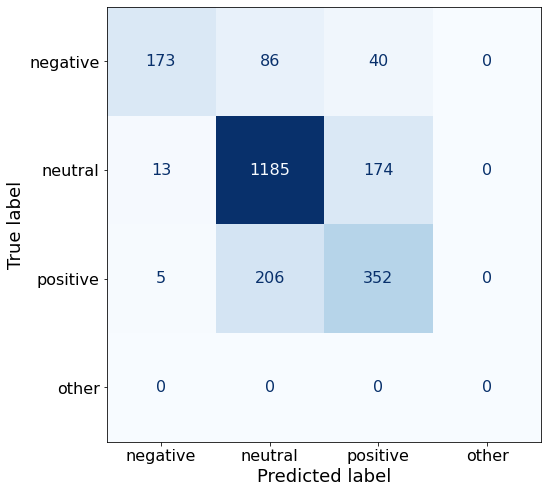

In [26]:
make_cm(df)

In [27]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AL.csv', index=False)

Two more 30-Shot prompts to go.

## Prompt AM

In [30]:
promptAM_ds, examples = get_ds(30)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
}) ['negative', 'neutral', 'positive', 'negative', 'neutral', 'neutral', 'positive', 'negative', 'positive', 'neutral']


In [31]:
df = few_shot_responses(promptAM_ds, promptJ, examples)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [32]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The overall accuracy doesn't improve but the model's performance on `negative` and `positive` sentences does.

In [33]:
get_acc(df)

0.7484333034914951

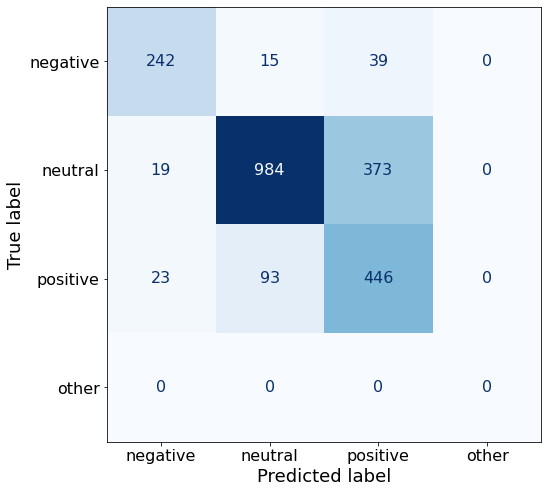

In [34]:
make_cm(df)

In [35]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AM.csv', index=False)

## Prompt AN

In [36]:
promptAN_ds, examples = get_ds(30)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
}) ['positive', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


In [37]:
df = few_shot_responses(promptAN_ds, promptJ, examples)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [38]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The overall accuracy doesn't improve but the model's performance on `positive` sentences does.

In [39]:
get_acc(df)

0.7381378692927484

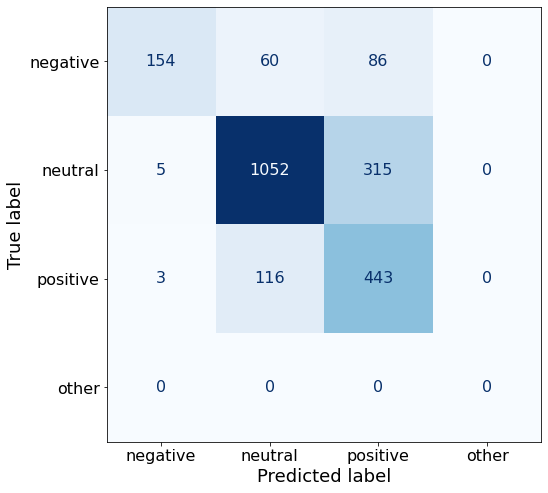

In [40]:
make_cm(df)

In [41]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AN.csv', index=False)

Next, I'll increase the number of examples to 45.

## Prompt AO

In [44]:
promptAO_ds, examples = get_ds(45)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2219
}) ['neutral', 'neutral', 'positive', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'positive', 'neutral']


In [45]:
df = few_shot_responses(promptAO_ds, promptJ, examples)

Map:   0%|          | 0/2219 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [46]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The overall accuracy doesn't improve but the model's performance on `positive` sentences does.

In [47]:
get_acc(df)

0.7417755745831456

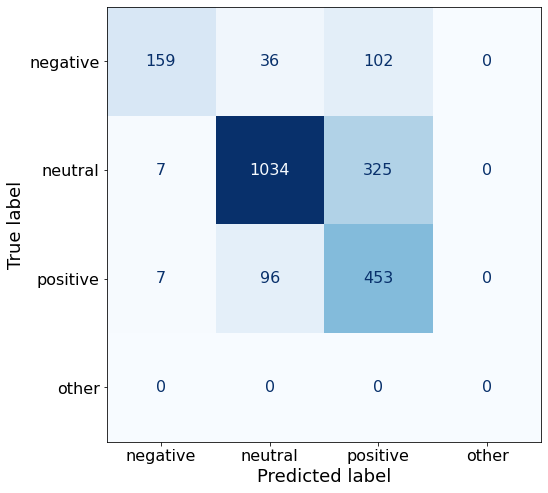

In [48]:
make_cm(df)

In [49]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AO.csv', index=False)

## Prompt AP

In [50]:
promptAP_ds, examples = get_ds(45)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2219
}) ['neutral', 'positive', 'negative', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'neutral', 'positive']


In [51]:
df = few_shot_responses(promptAP_ds, promptJ, examples)

Map:   0%|          | 0/2219 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [52]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The overall accuracy doesn't improve but the model's performance on `neutral` sentences does.

In [53]:
get_acc(df)

0.7872915727805317

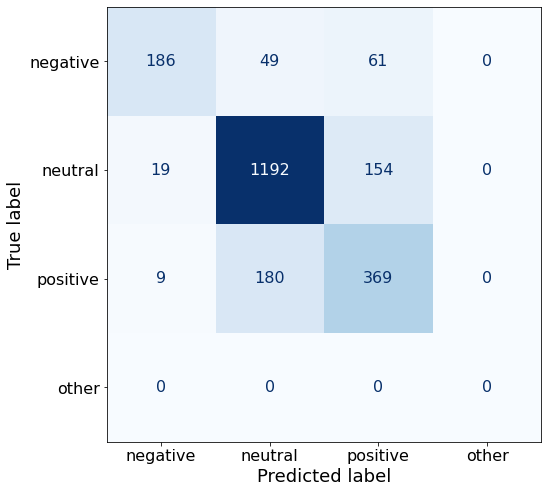

In [54]:
make_cm(df)

In [55]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AP.csv', index=False)

## Prompt AQ

In [56]:
promptAQ_ds, examples = get_ds(45)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2219
}) ['neutral', 'neutral', 'negative', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'neutral']


In [57]:
df = few_shot_responses(promptAQ_ds, promptJ, examples)

Map:   0%|          | 0/2219 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [58]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The overall accuracy doesn't improve but the model's performance on `neutral` sentences does.

In [59]:
get_acc(df)

0.7201442091031997

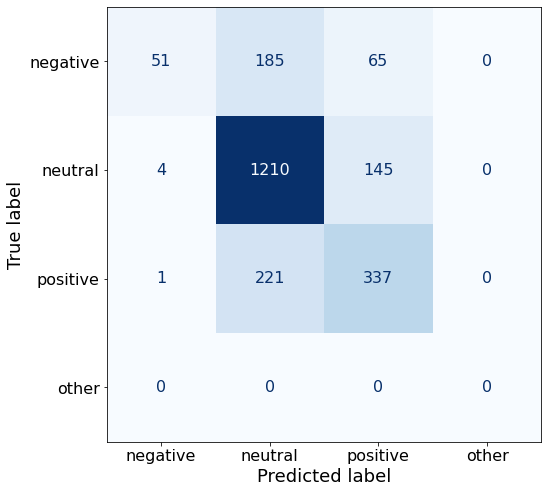

In [60]:
make_cm(df)

In [61]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AQ.csv', index=False)

## Prompt AR

In [16]:
promptAR_ds, examples = get_ds(45)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2219
}) ['neutral', 'negative', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'positive']


In [17]:
df = few_shot_responses(promptAR_ds, promptJ, examples)

Map:   0%|          | 0/2219 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [18]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt performs worse than the best overall Prompt AA.

In [19]:
get_acc(df)

0.7386210004506535

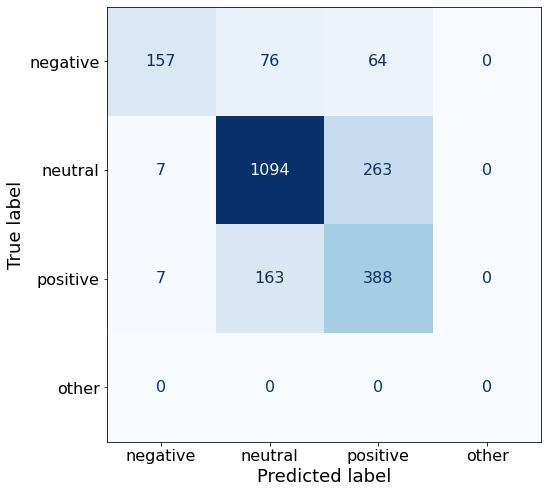

In [20]:
make_cm(df)

In [21]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AR.csv', index=False)

## Prompt AS

In [15]:
promptAS_ds, examples = get_ds(45)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2219
}) ['neutral', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


In [16]:
df = few_shot_responses(promptAS_ds, promptJ, examples)

Map:   0%|          | 0/2219 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [17]:
df['responses'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

Compared to Prompt AA, this prompt yields a worse overall accuracy but improves on `neutral` sentences (1291 > 1180).

In [18]:
get_acc(df)

0.7494366831906264

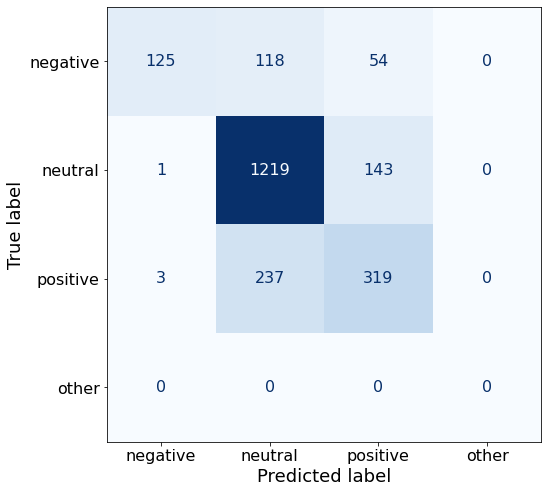

In [19]:
make_cm(df)

In [20]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AS.csv', index=False)

Next, I'll move on to the final number of examples: 60.

## Prompt AT

In [22]:
promptAT_ds, examples = get_ds(60)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2204
}) ['positive', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'negative', 'neutral']


In [23]:
df = few_shot_responses(promptAT_ds, promptJ, examples)

Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [24]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Upping the number of examples to 60 does not improve results.

In [25]:
get_acc(df)

0.7218693284936479

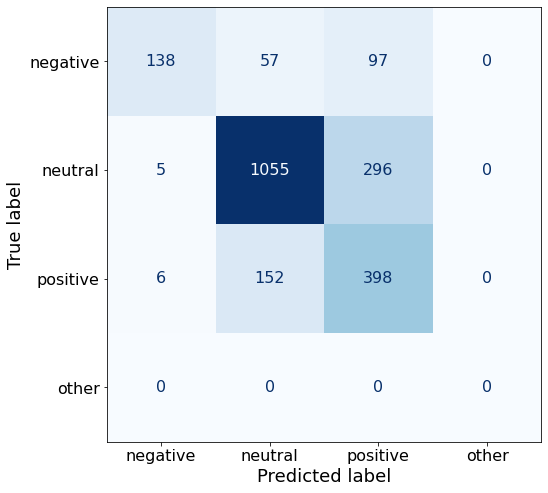

In [26]:
make_cm(df)

In [27]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AT.csv', index=False)

## Prompt AU

In [30]:
promptAU_ds, examples = get_ds(60)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2204
}) ['neutral', 'positive', 'neutral', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'neutral']


In [32]:
df = few_shot_responses(promptAU_ds, promptJ, examples)

Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [33]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Compared to Prompt AA, this prompt yields a worse overall accuracy but improves on `neutral` sentences (1237 > 1180).

In [34]:
get_acc(df)

0.7686025408348457

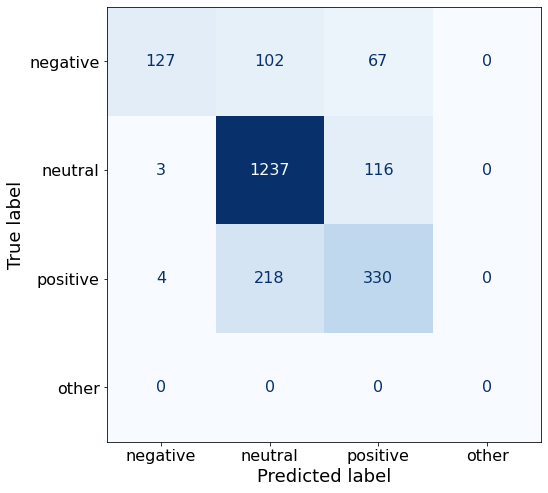

In [35]:
make_cm(df)

In [36]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AU.csv', index=False)

## Prompt AV

In [38]:
promptAV_ds, examples = get_ds(60)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2204
}) ['positive', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'positive', 'negative', 'neutral']


In [39]:
df = few_shot_responses(promptAV_ds, promptJ, examples)

Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [40]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Compared to Prompt AA, this prompt yields a worse overall accuracy but improves on `neutral` sentences (1206 > 1180).

In [41]:
get_acc(df)

0.7545372050816697

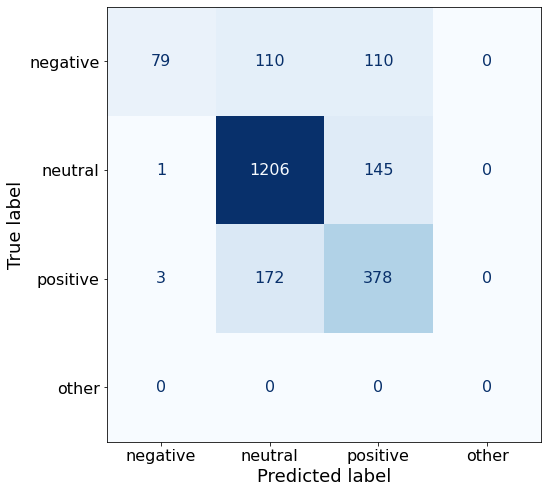

In [42]:
make_cm(df)

In [43]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AV.csv', index=False)

## Prompt AW

In [17]:
promptAW_ds, examples = get_ds(60)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2204
}) ['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral']


In [18]:
df = few_shot_responses(promptAW_ds, promptJ, examples)

Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [19]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

This prompt does not improve upon Prompt AA results.

In [20]:
get_acc(df)

0.7445553539019963

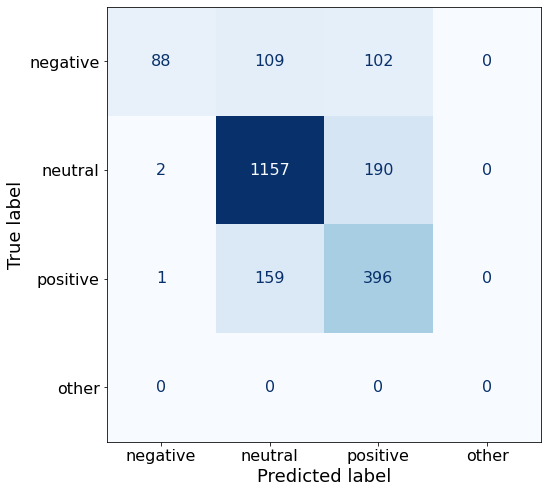

In [21]:
make_cm(df)

In [22]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AW.csv', index=False)

## Prompt AX

In [24]:
promptAX_ds, examples = get_ds(60)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2204
}) ['neutral', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'negative']


In [25]:
df = few_shot_responses(promptAX_ds, promptJ, examples)

Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Label the following TEXT with a single word: positive, negative, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [26]:
df['responses'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

Aha! We finally improve on the overall accuracy of Prompt AA. This prompt yields a slightly higher accuracy that still 
rounds off to 80%.

In [27]:
get_acc(df)

0.7962794918330308

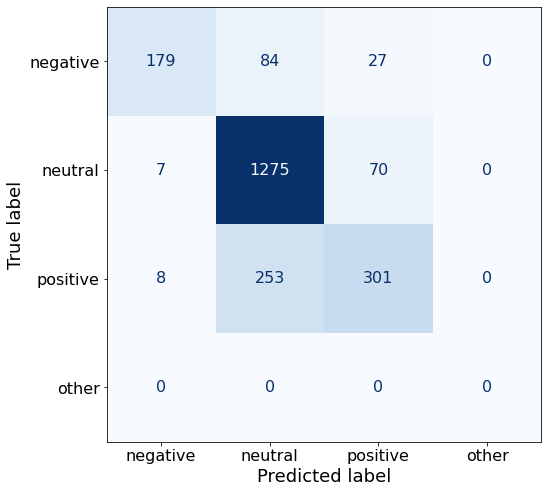

In [36]:
make_cm(df)

In [28]:
df.to_csv('/notebooks/Qwen2-0.5B-Instruct_AX.csv', index=False)

## Running Inference 10 Times Using the Best Prompt

While 60-shot Prompt AX had a slightly higher accuracy (79.63%) I am going to pick the 16-Shot Prompt AA as my best prompt (79.48%) since it has less than a 
third of the examples, which translates to about a third of the tokens, thus leading to quicker response generation.

In [17]:
def test_gen(examples):
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": promptJ.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    messages = few_shot_examples + [{"role": "user", "content": promptJ.format(text=dataset[0]['sentence'])}]
        
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=2
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
    return response

In [18]:
promptAA_ds, examples = get_ds(18)

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2246
}) ['negative', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'positive']


1 response generation takes 72ms. Running full dataset inference 10 times will take about 30 minutes.

In [19]:
%timeit -n 10 test_gen(examples)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


72 ms ± 42.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
#| code-fold: true
#| code-summary: "Show updated `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    for row in dataset:
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=2
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
        responses.append(response)
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    
    return df, acc

In [38]:
#| code-fold: true
#| code-summary: "Show updated `get_ds` function"
def get_ds(n):
    exclude_idxs = [random.randint(0, 2263) for _ in range(n)]
    prompt_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)

    examples = []
    for idx in exclude_idxs:
        examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))
    
    return prompt_ds, examples

I didn't store the exact 18 examples that I used the first time for Prompt AA, so I had to try different 18-Shot examples until I achieved an accuracy 
close to 79.48%. It took me about 20 tries, but I finally found a set of examples that broke the 79% threshold.

In [ ]:
for _ in range(20):
    n = 18
    ds, examples = get_ds(n)
    if len(ds) != 2264 - n: pass
    df, acc = few_shot_responses(ds, promptJ, examples)
    if round(acc, 2) >= 0.79: break

In [42]:
acc

0.815227070347284

In [44]:
ds, len(examples)

(Dataset({
     features: ['sentence', 'label', 'label_text', '__index_level_0__'],
     num_rows: 2246
 }),
 18)

In [ ]:
accs = []
for _ in range(10):
    df, acc = few_shot_responses(ds, promptJ, examples)
    accs.append(acc)

For this prompt, the overall accuracy ranges from 80.8% to 82.4%.

In [46]:
pd.Series(accs).describe()

count    10.000000
mean      0.816830
std       0.005397
min       0.807658
25%       0.814003
50%       0.817453
75%       0.819791
max       0.824577
dtype: float64

## Final Thoughts

Takeaways from my Qwen2-0.5B experiments:

- **Example order matters**: Testing 6 prompts with the same 3 examples in different orders yielded accuracies from 57% to 75%.  
- **Example selection matters**: Recreating the performance of one of my best prompts (79.48% accuracy) took ~20 attempts, proving not all sets of examples perform equally.  
- **Result variance exists**: Running a prompt 10 times produced accuracies ranging from 80.8% to 82.4%.  

Here are the results of Qwen2-0.5B in the context of the other models that I have experimented with:

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|phi-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|
|Qwen2-1.5B|27-Shot|86.10%|90% (264/294)|96% (1320/1382)|61% (342/561)|
|\**Qwen2-0.5B|17-Shot|79.48%|69% (206/300)|86% (1180/1380)|71% (400/567)|

Here are the results from this notebook:

| Prompt | Strategy | Accuracy | Negative | Neutral | Positive |
|--------|----------|-----------|-----------|----------|-----------|
| [A](#prompt-a) | 0-Shot | 62.41% | 91% (276/303) | 53% (735/1391) | 71% (402/570) |
| [B](#prompt-b) | 0-Shot | 47.84% | 90% (274/303) | 57% (789/1391) | 4% (20/570) |
| [C](#prompt-c) | 0-Shot | 40.46% | 91% (276/303) | 43% (594/1391) | 8% (46/570) |
| [D](#prompt-d) | 0-Shot | 68.29% | 79% (240/303) | 61% (851/1391) | 80% (455/570) |
| [E](#prompt-e) | 0-Shot | 51.19% | 97% (293/303) | 28% (396/1391) | 82% (470/570) |
| [F](#prompt-f) | 0-Shot | 48.19% | 94% (286/303) | 21% (287/1391) | 91% (518/570) |
| [G](#prompt-g) | 0-Shot | 61.09% | 93% (282/303) | 46% (646/1391) | 80% (455/570) |
| [H](#prompt-h) | 0-Shot | 65.42% | 85% (257/303) | 57% (798/1391) | 75% (426/570) |
| [I](#prompt-i) | 0-Shot | 66.12% | 81% (245/303) | 58% (800/1391) | 79% (452/570) |
| [J](#prompt-j) | 3-Shot | 70.94% | 43% (131/302) | 75% (1042/1390) | 76% (431/569) |
| [K](#prompt-k) | 3-Shot | 74.88% | 67% (201/302) | 75% (1043/1390) | 79% (449/569) |
| [L](#prompt-l) | 3-Shot | 68.11% | 49% (149/302) | 65% (900/1390) | 86% (491/569) |
| [M](#prompt-m) | 3-Shot | 56.97% | 49% (149/302) | 45% (625/1390) | 90% (514/569) |
| [N](#prompt-n) | 3-Shot | 73.95% | 62% (188/302) | 75% (1038/1390) | 78% (446/569) |
| [O](#prompt-o) | 3-Shot | 59.97% | 65% (196/302) | 46% (635/1390) | 92% (525/569) |
| [P](#prompt-p) | 6-Shot | 63.91% | 95% (289/303) | 49% (678/1389) | 84% (476/566) |
| [Q](#prompt-q) | 6-Shot | 65.72% | 69% (207/302) | 55% (765/1389) | 90% (512/567) |
| [R](#prompt-r) | 6-Shot | 64.84% | 94% (285/303) | 49% (686/1387) | 87% (493/568) |
| [S](#prompt-s) | 6-Shot | 62.98% | 96% (292/303) | 47% (656/1387) | 83% (474/568) |
| [T](#prompt-t) | 6-Shot | 68.87% | 51% (155/302) | 70% (966/1387) | 76% (434/569) |
| [U](#prompt-u) | 12-Shot | 65.50% | 53% (159/302) | 59% (820/1386) | 88% (496/564) |
| [V](#prompt-v) | 12-Shot | 73.22% | 70% (209/300) | 80% (1103/1386) | 60% (337/566) |
| [W](#prompt-w) | 12-Shot | 70.43% | 82% (246/301) | 66% (912/1384) | 75% (428/567) |
| [X](#prompt-x) | 12-Shot | 76.60% | 91% (270/298) | 72% (1000/1386) | 80% (455/568) |
| [Y](#prompt-y) | 12-Shot | 72.56% | 80% (243/303) | 77% (1069/1381) | 57% (322/568) |
| [Z](#prompt-z) | 18-Shot | 71.33% | 50% (150/301) | 75% (1036/1382) | 74% (416/563) |
| **[AA](#prompt-aa)** | **17-Shot** | **79.48%** | 69% (206/300) | 86% (1180/1380) | 71% (400/567) |
| [AB](#prompt-ab) | 18-Shot | 74.22% | 77% (229/299) | 76% (1054/1381) | 68% (384/566) |
| [AC](#prompt-ac) | 18-Shot | 68.57% | 49% (148/302) | 73% (1013/1380) | 67% (379/564) |
| [AD](#prompt-ad) | 18-Shot | 74.98% | 89% (271/303) | 76% (1052/1379) | 64% (361/564) |
| [AE](#prompt-ae) | 24-Shot | 74.91% | 61% (181/299) | 92% (1267/1375) | 41% (230/566) |
| [AF](#prompt-af) | 24-Shot | 73.08% | 37% (112/302) | 91% (1246/1375) | 50% (279/563) |
| [AG](#prompt-ag) | 24-Shot | 75.00% | 58% (173/300) | 92% (1265/1375) | 43% (242/565) |
| [AH](#prompt-ah) | 24-Shot | 77.46% | 78% (233/299) | 84% (1153/1375) | 62% (349/566) |
| [AI](#prompt-ai) | 23-Shot | 75.37% | 48% (143/301) | 92% (1266/1375) | 50% (280/565) |
| [AJ](#prompt-aj) | 30-Shot | 77.39% | 58% (172/298) | 94% (1284/1370) | 48% (273/566) |
| [AK](#prompt-ak) | 30-Shot | 67.78% | 63% (187/299) | 61% (844/1375) | 86% (483/560) |
| [AL](#prompt-al) | 30-Shot | 76.54% | 58% (173/299) | 86% (1185/1372) | 63% (352/563) |
| [AM](#prompt-am) | 30-Shot | 74.84% | 82% (242/296) | 72% (984/1376) | 79% (446/562) |
| [AN](#prompt-an) | 30-Shot | 73.81% | 51% (154/300) | 77% (1052/1372) | 79% (443/562) |
| [AO](#prompt-ao) | 45-Shot | 74.18% | 54% (159/297) | 76% (1034/1366) | 81% (453/556) |
| [AP](#prompt-ap) | 45-Shot | 78.73% | 63% (186/296) | 87% (1192/1365) | 66% (369/558) |
| [AQ](#prompt-aq) | 45-Shot | 72.01% | 17% (51/301) | 89% (1210/1359) | 60% (337/559) |
| [AR](#prompt-ar) | 45-Shot | 73.86% | 53% (157/297) | 80% (1094/1364) | 70% (388/558) |
| [AS](#prompt-as) | 45-Shot | 74.94% | 42% (125/297) | 89% (1219/1363) | 57% (319/559) |
| [AT](#prompt-at) | 60-Shot | 72.19% | 47% (138/292) | 78% (1055/1356) | 72% (398/556) |
| [AU](#prompt-au) | 60-Shot | 76.86% | 43% (127/296) | 91% (1237/1356) | 60% (330/552) |
| [AV](#prompt-av) | 60-Shot | 75.45% | 26% (79/299) | 89% (1206/1352) | 68% (378/553) |
| [AW](#prompt-aw) | 60-Shot | 74.46% | 29% (88/299) | 86% (1157/1349) | 71% (396/556) |
| **[AX](#prompt-ax)** | **60-Shot** | **79.63%** | 62% (179/290) | 94% (1275/1352) | 54% (301/562) |
